In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print(f"tf   {tf.__version__}")
print(f"tfds {tfds.__version__}")
print(f"hub  {hub.__version__}")

tf   2.9.2
tfds 4.6.0
hub  0.12.0


### Load an image dataset

We load the caltech 101 datasets:
https://data.caltech.edu/records/mzrjq-6wc02

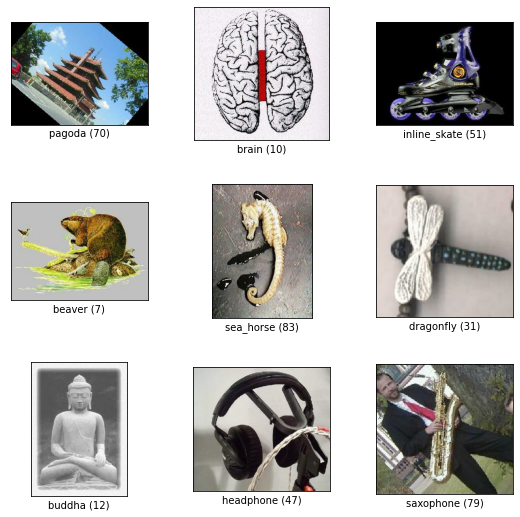

In [ ]:
ds, ds_info = tfds.load('caltech101', split='train', with_info=True, as_supervised=True)
fig = tfds.show_examples(ds, ds_info)

### Load a pre-trained classification model

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3, decode_predictions 

# EfficientNetV2B3 expects image size of (300, 300)
model = EfficientNetV2B3(weights="imagenet", include_top=True)
model.trainable = False

# check the names of the last conv layer, and the last dense layer
#model.summary()

58758896/58758896 [==============================] - 0s 0us/step


Note that for accurate predictions we should retrain the classification layer on the given dataset.

However, this does not affect the principle of the activation maps, and it is actually interesting to see cases of missclassification (or correct ones but with different labels) and the corresponding activation maps.

### Plot the class activation maps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_class_activation_map(model, ds, ds_info, n=10):

  # Modify the model to also output the features from the last conv layer
  feature_extractor = tf.keras.Model(model.inputs,
    [model.output, model.get_layer("top_conv").output])

  # Class weight matrix of the classification layer
  W = feature_extractor.get_layer("predictions").get_weights()[0]
  
  # Iterate through n images from the dataset
  for image, target in tfds.as_numpy(ds.take(n)):

    # Resize the image (and add the batch dimension expected by the model)
    input_size = feature_extractor.layers[0].output_shape[0][1:3]  # (300, 300)
    x = tf.image.resize(image, input_size[0:2])  # shape=(300, 300, 3)
    x = np.expand_dims(x, 0)  # shape=(1, 300, 300, 3)

    # Get class probs and conv features for the image
    probs, features = feature_extractor.predict(x)
    features = features[0]  # shape=(10, 10, 1536)

    # Get the weights for the predicted class
    y = np.argmax(probs[0])
    w = W[:, y]  # shape=(1536,)

    # Calculate the Class Activation Map (resized to image.shape for superposed plot)
    cam = features.dot(w)  # shape=(10, 10)
    cam = tf.image.resize(np.expand_dims(cam, 2), image.shape[0:2], antialias=True)  # shape=(x, y, 1)
    cam = tf.squeeze(cam)  # shape=(x, y)

    # Plot
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    axs[0].imshow(image)
    target_label = ds_info.features['label'].int2str(target)
    #target_label = ds_info.features['label'].names[target]
    axs[0].set_title(f"{target_label}")
    axs[1].imshow(image, alpha=0.8)
    axs[1].imshow(cam, cmap='jet', alpha=0.5)
    prediction_labels = [el[1:] for el in decode_predictions(probs)[0]]
    axs[1].set_title(f"predicted: {prediction_labels[0][0]}")
    plt.show()
    print(prediction_labels)

35363/35363 [==============================] - 0s 0us/step


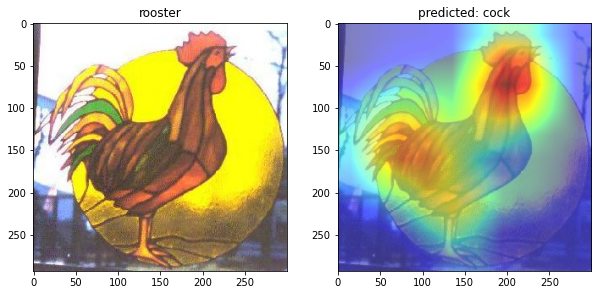

[('cock', 0.50712216), ('prairie_chicken', 0.079640456), ('book_jacket', 0.034206223), ('partridge', 0.027697042), ('comic_book', 0.025338607)]
1/1 [==============================] - 0s 279ms/step


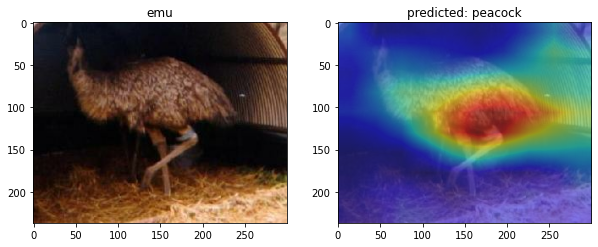

[('peacock', 0.091375574), ('ostrich', 0.07413067), ('wombat', 0.06699358), ('hare', 0.0368801), ('wallaby', 0.031992976)]
1/1 [==============================] - 0s 246ms/step


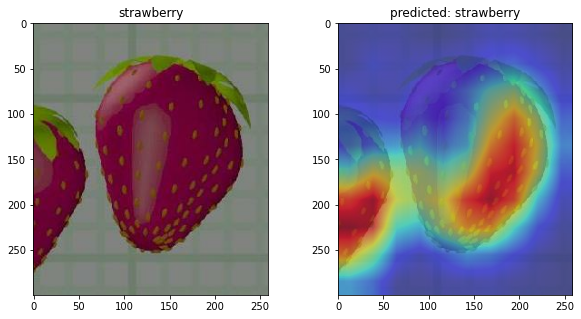

[('strawberry', 0.5774034), ('maraca', 0.27457452), ('balloon', 0.016446998), ('clog', 0.008637489), ('Granny_Smith', 0.005259584)]
1/1 [==============================] - 0s 272ms/step


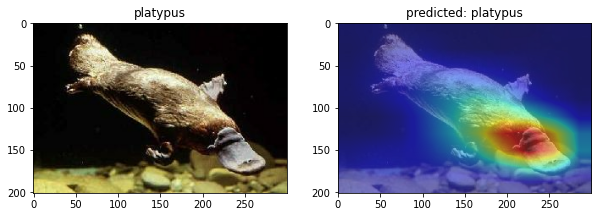

[('platypus', 0.9527249), ('beaver', 0.00087464094), ('chocolate_sauce', 0.00027824237), ('mink', 0.00026132268), ('water_ouzel', 0.00024508225)]
1/1 [==============================] - 0s 295ms/step


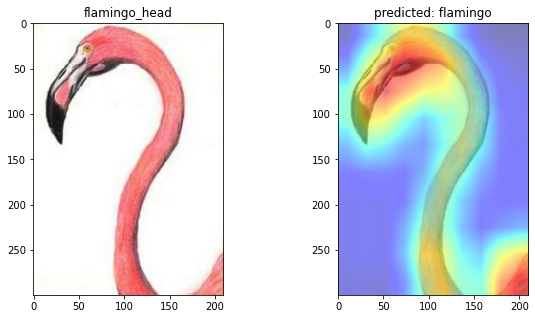

[('flamingo', 0.8160255), ('hook', 0.067299195), ('macaw', 0.0059838216), ('nematode', 0.0052829026), ('crane', 0.0032774957)]
1/1 [==============================] - 0s 269ms/step


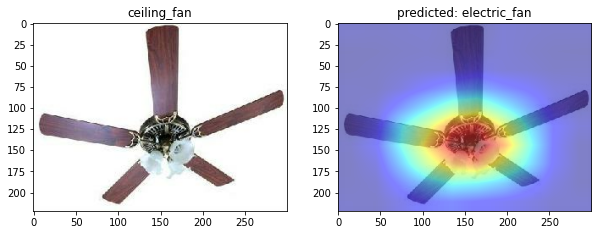

[('electric_fan', 0.94544894), ('pinwheel', 0.0025758045), ('hair_slide', 0.0016667201), ('buckle', 0.0011194932), ('letter_opener', 0.00065941154)]
1/1 [==============================] - 0s 424ms/step


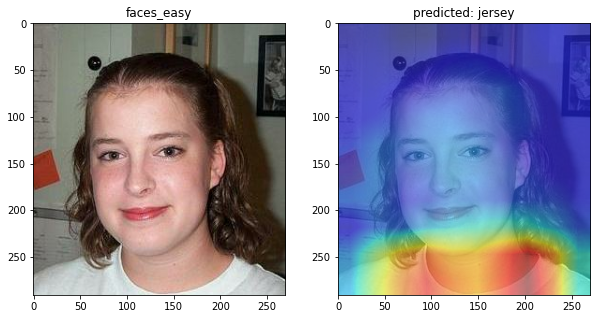

[('jersey', 0.18553168), ('spatula', 0.052176133), ('lab_coat', 0.030785182), ('neck_brace', 0.028458416), ('pajama', 0.02449511)]
1/1 [==============================] - 0s 442ms/step


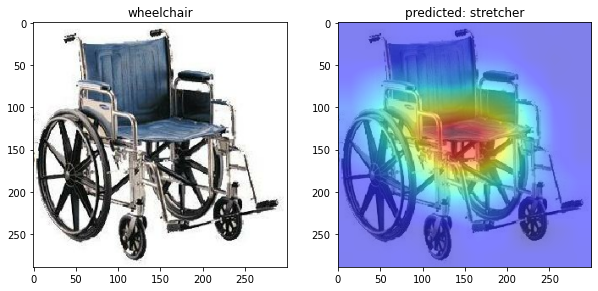

[('stretcher', 0.9076648), ('jinrikisha', 0.00453336), ('tricycle', 0.002683922), ('horse_cart', 0.0023011027), ('rocking_chair', 0.0009360472)]
1/1 [==============================] - 0s 450ms/step


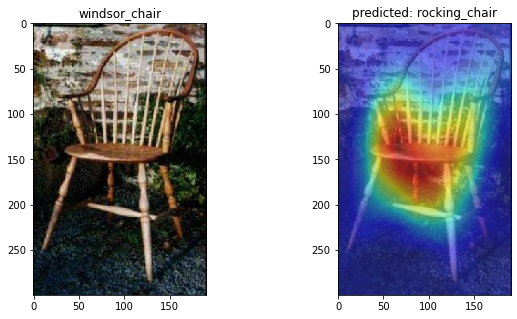

[('rocking_chair', 0.9120898), ('cradle', 0.0065445984), ('dining_table', 0.0012945305), ('park_bench', 0.0010063879), ('bassinet', 0.00095880305)]
1/1 [==============================] - 0s 286ms/step


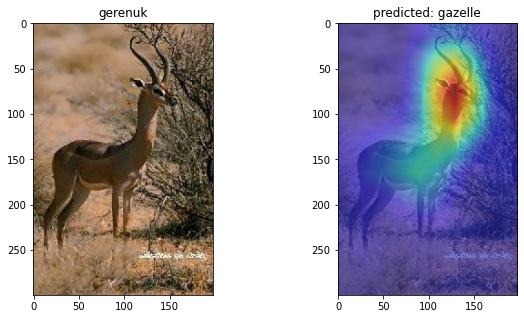

[('gazelle', 0.585583), ('impala', 0.30433145), ('hartebeest', 0.013766582), ('ibex', 0.0010174979), ('zebra', 0.0008674984)]


In [ ]:
plot_class_activation_map(model, ds.shuffle(10000), ds_info)

### TODO: retrain the classification layer and plot the activation maps